In [1]:
import GERecon

#### From: https://suspect.readthedocs.io/en/latest/notebooks/consensus_playground.html

In [2]:
#print(GERecon.Options())

In [3]:
import os, sys
import suspect
import numpy as np
from matplotlib import pyplot as plt
import subprocess

In [4]:
!ls -lFG ~/data/

total 0
drwxr-xr-x 15 jovyan 480 Oct 13 19:08 01/
drwxr-xr-x 10 jovyan 320 May 10 15:11 _1_scripts/
drwxr-xr-x  4 jovyan 128 Apr 26 16:39 _2_results/
drwxr-xr-x  6 jovyan 192 Apr  1  2023 _3_docs/
drwxrwxrwx  6 jovyan 192 Apr 11  2023 exampledata/


In [66]:
!tree -L 2 ~/lcmodel/basis-sets/ge-3t/
BASIS_SET = '/home/jovyan/lcmodel/basis-sets/ge-3t/press_te35_3t_v3.basis'

/home/jovyan/lcmodel/basis-sets/ge-3t/
├── all
│   ├── gamma_press_te144_3t_all_v1.basis
│   ├── gamma_press_te20_3t_all_v1.basis
│   ├── gamma_press_te270_3t_all_v1.basis
│   ├── gamma_press_te288_3t_all_v1.basis
│   ├── gamma_press_te40_3t_all_v1.basis
│   ├── gamma_press_te68_3t_all_v1.basis
│   ├── gamma_press_te80_3t_all_v1.basis
│   ├── gamma_te0_3t_all_v1.basis
│   ├── press_te135_3t_all_v3.basis
│   ├── press_te25_3t_all_v3.basis
│   ├── press_te30_3t_all_v3.basis
│   └── press_te35_3t_all_v3.basis
├── gamma_press_te144_3t_v1.basis
├── gamma_press_te20_3t_v1.basis
├── gamma_press_te270_3t_v1.basis
├── gamma_press_te288_3t_v1.basis
├── gamma_press_te40_3t_v1.basis
├── gamma_press_te68_3t_v1.basis
├── gamma_press_te80_3t_v1.basis
├── gamma_te0_3t_v1.basis
├── press_te135_3t_v3.basis
├── press_te25_3t_v3.basis
├── press_te30_3t_v3.basis
├── press_te35_3t_v3.basis
├── README-3t.txt
└── steam_te20_3t_01a.basis

1 directory, 26 files


In [67]:
pfile_bn = 'P20992.7'
data_dir = '/home/jovyan/data/01/'+pfile_bn+'_suspect'
pfile_fn = os.path.join(data_dir, pfile_bn)
print(pfile_fn)

/home/jovyan/data/01/P20992.7_suspect/P20992.7


In [64]:
data,wref = suspect.io.load_pfile(pfile_fn)

In [28]:
print(type(data))
print(data)
print(data.sw)
print(data.metadata)
print(data.shape)

<class 'suspect.mrsobjects.MRSData'>
<MRSBase instance f0=127.64584959999999MHz TE=40.0ms dt=0.2ms>
5000.0
None
(16, 32, 4096)


## DATA.shape

From .shape property above, data has 16 averages, 32 channels and 4096 ADC points in the FID.

Text(0.5, 1.0, 'data(avg-01,chan-01)')

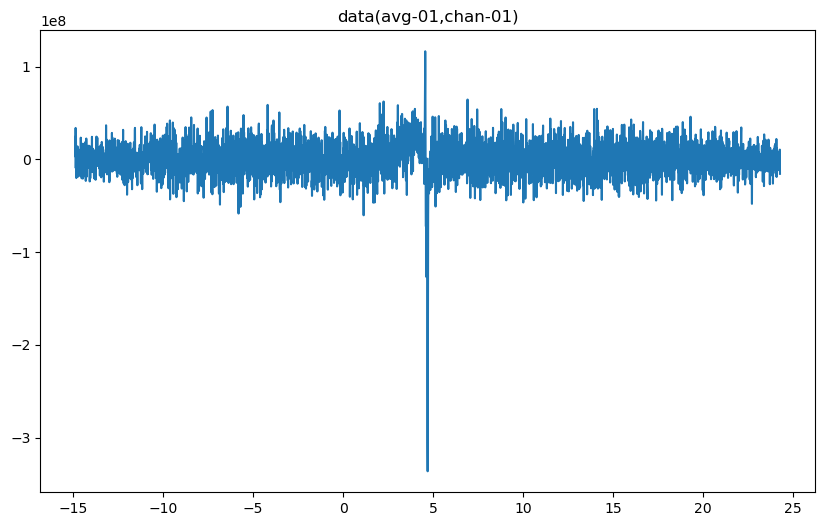

In [29]:
plt.figure(figsize=(10,6))
plt.plot(data[1,1,:].frequency_axis_ppm(), data[1,1,:].spectrum().real)
plt.title('data(avg-01,chan-01)')

In [30]:
print(wref)
print(wref.sw)
print(wref.metadata)
print(wref.shape)

<MRSBase instance f0=127.64584959999999MHz TE=40.0ms dt=0.2ms>
5000.0
None
(2, 32, 4096)


## WREF.shape

From .shape property above, wref has 16 averages, 32 channels and 4096 ADC points in the FID.

Text(0.5, 1.0, 'wref(avg-01,chan-01)')

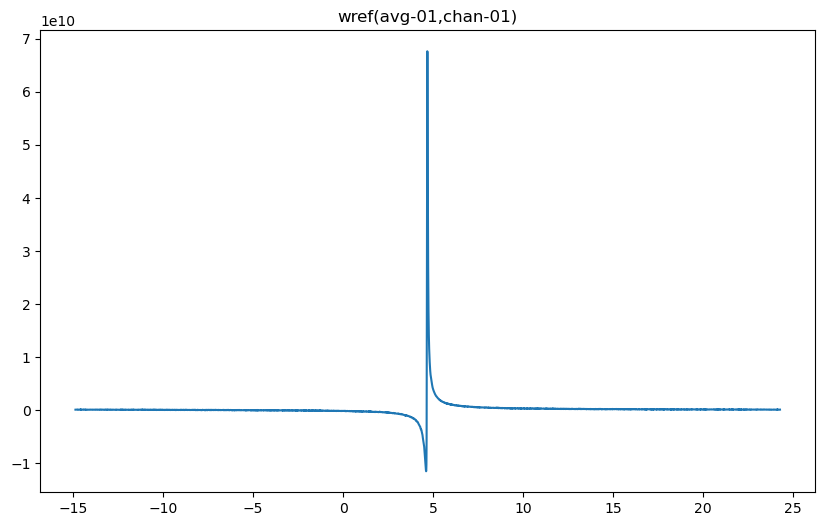

In [31]:
plt.figure(figsize=(10,6))
plt.plot(wref[1,1,:].frequency_axis_ppm(), wref[1,1,:].spectrum().real)
plt.title('wref(avg-01,chan-01)')

## Channel Combination - WSVD method

Because this is multi-channel data, there is likely to be some level of correlation between some of the channels. We can check this by looking at the pure noise signal at the end of the FIDs. From the covariance matrix below we can see that there is indeed substantial correlation between various pairs of coils, and also variation in the magnitude of the signal from different coils.

## channel combination - SVD
The first step in processing this single voxel data is to combine the data from all the individual channels. We could just average them all together, but this won't give the maximum signal to noise ratio. We want to give a stronger weighting to the channels which already have the highest SNR and we can do this using the svd_weighting function provided by suspect in the processing.channel_combination module.
 https://github.com/bkossows/openmrslab/blob/lcmodel/examples/TwixFrequencyCorrection.ipynb

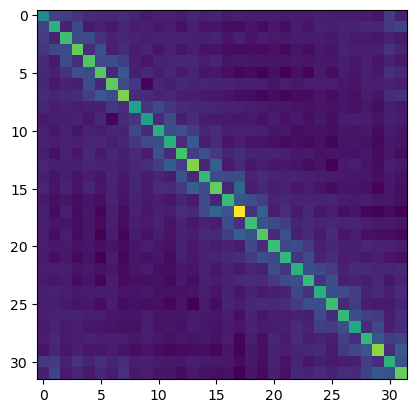

In [32]:
noise_points = 256
noise = data[:, :, -noise_points:]
noise = np.moveaxis(noise, -2, 0).reshape((32, -1))
plt.imshow(np.cov(noise).real)

We can correct for this and “whiten” the noise using the method described in Rodgers, C. T., & Robson, M. D. (2010). Receive array magnetic resonance spectroscopy: Whitened singular value decomposition (WSVD) gives optimal Bayesian solution. Magnetic Resonance in Medicine, 63(4), 881–891. This creates a set of “virtual channels” as linear combinations of the real channels, producing zero correlation and equal magnitude of each channel.

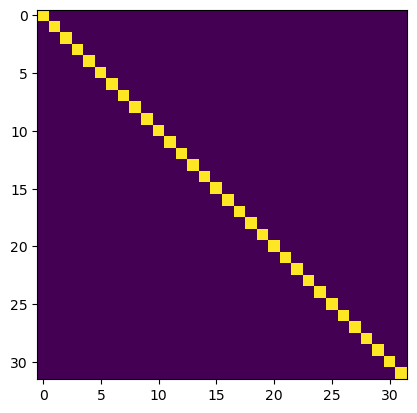

In [33]:
white_data = suspect.processing.channel_combination.whiten(data, noise)
white_wref = suspect.processing.channel_combination.whiten(wref, noise)
noise = white_data[:, :, -noise_points:]
noise = np.moveaxis(noise, -2, 0).reshape((32, -1))
plt.imshow(np.cov(noise).real)

We then combine these virtual channels using the SVD weighting method proposed in the same paper. In this case we take the weightings for both datasets from the water reference signal for consistency, as the water reference has a greater overall SNR.

In [34]:
channel_weights = suspect.processing.channel_combination.svd_weighting(np.mean(white_wref, axis=0))
cc_data = suspect.processing.channel_combination.combine_channels(white_data, channel_weights)
cc_wref = suspect.processing.channel_combination.combine_channels(white_wref, channel_weights)
print(cc_data.shape)
print(cc_wref.shape)

(16, 4096)
(2, 4096)


In [35]:
## combining-channels w/o fancy whitening or SNR-weights:
data_CC = suspect.processing.channel_combination.combine_channels(data)
wref_CC = suspect.processing.channel_combination.combine_channels(wref)
print(data_CC.shape)
print(wref_CC.shape)

(16, 4096)
(2, 4096)


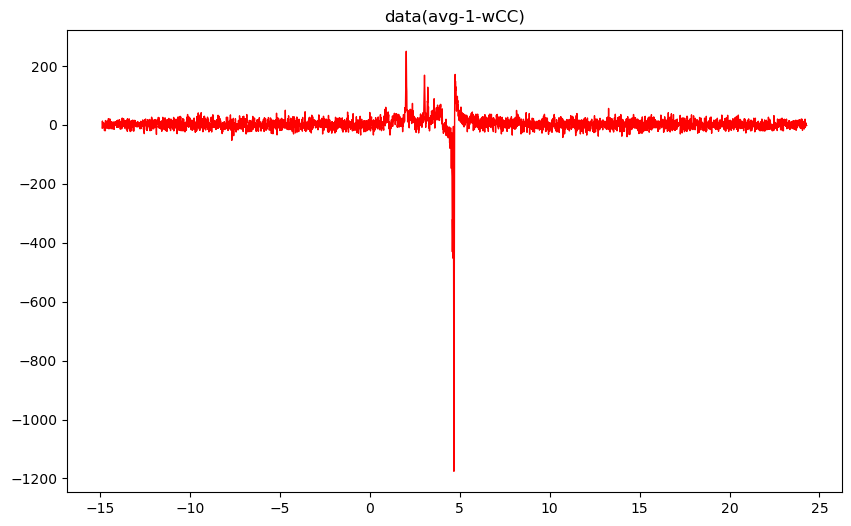

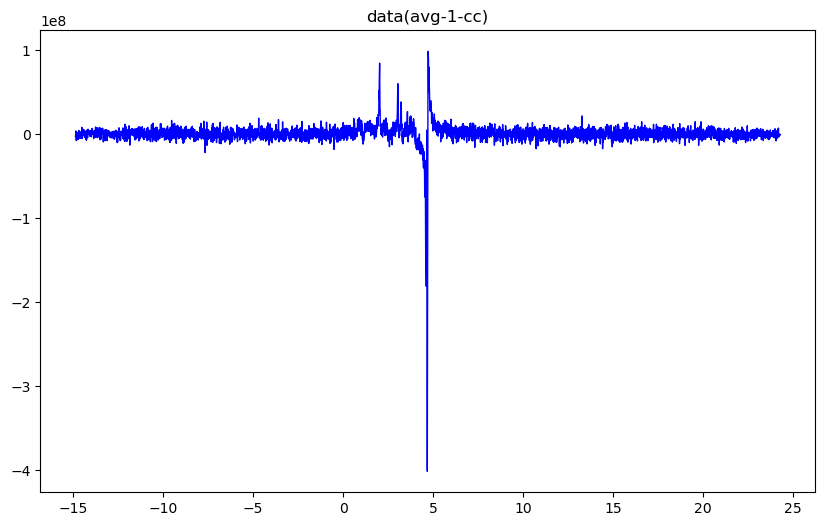

In [36]:
## compare 
plt.figure(figsize=(10,6))
plt.plot(cc_data[1,:].frequency_axis_ppm(), cc_data[1,:].spectrum().real, color='r', linestyle='solid', linewidth=1)
plt.title('data(avg-1-wCC)')
plt.show()
plt.figure(figsize=(10,6))
plt.plot(data_CC[1,:].frequency_axis_ppm(), data_CC[1,:].spectrum().real, color='b', linestyle='solid', linewidth=1)
plt.title('data(avg-1-cc)')
plt.show()

## Frequency Drift Correction

Now it is time to check for frequency drift. In this demonstration we use a visualisation method borrowed from GANNET where we show the sequence of spectra as a heatmap. We can easily convert from a time domain FID representation of the data to spectra using the spectrum() method of the MRSData class. We then use the slice_ppm() method to index into the spectra in the range of frequencies we are interested in.

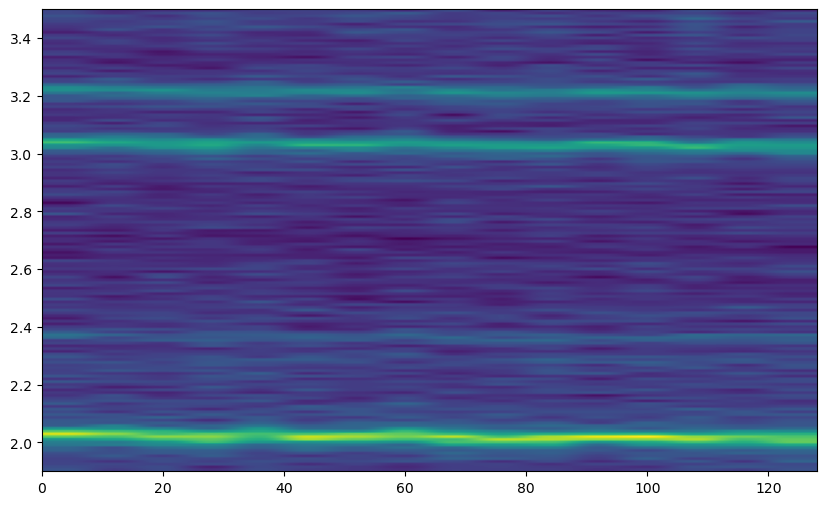

In [37]:
spectra = cc_data.spectrum()
frequency_slice = spectra.slice_ppm(3.5, 1.9)
plt.figure(figsize=(10,6))
plt.imshow(spectra[:, frequency_slice].T.real, extent=[0, 128, 1.9, 3.5], aspect='auto')

Despite the prospective frequency correction, a fairly pronounced drift in frequency is still visible over the 16 averages, this adds up to about 3Hz first spectrum to last. We can correct for that using Jamie Near’s time domain Spectral Registration method. We use the first average in the list as the target and iterate over all averages, correcting them to maximum alignment with that target. Note that alternative methods such as Martin Wilson’s RATS are also available. We also take the opportunity to make the same correction to the water reference data, although the drift in that case is likely minimal due to the reduced number of averages. Plotting the heatmap on the aligned data we can see that the drift is removed very effectively.

In [38]:
sr_data = suspect.processing.frequency_correction.correct_frequency_and_phase(cc_data, cc_data[0], method="sr")
sr_wref = suspect.processing.frequency_correction.correct_frequency_and_phase(cc_wref, cc_wref[0], method="sr")
print(sr_data.shape)
print(sr_wref.shape)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


(16, 4096)
(2, 4096)


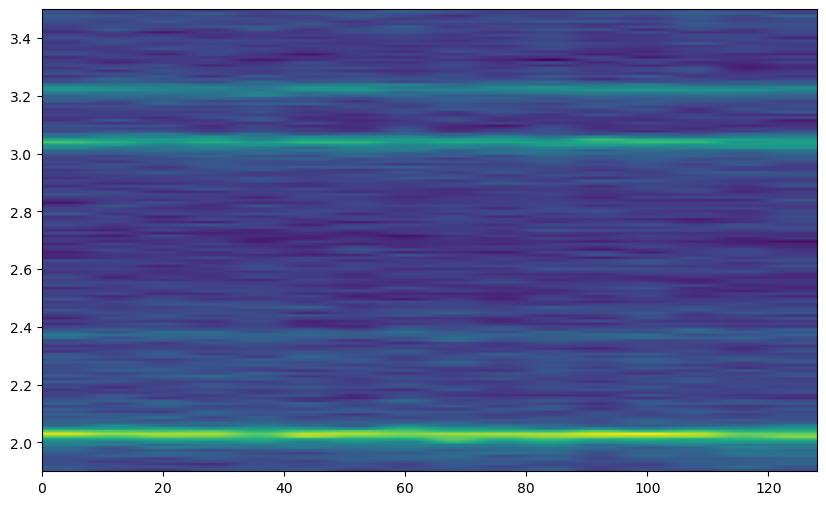

In [39]:
sr_spectra = sr_data.spectrum()
frequency_slice = sr_spectra.slice_ppm(3.5, 1.9)
plt.figure(figsize=(10,6))
plt.imshow(sr_spectra[:, frequency_slice].T.real, extent=[0, 128, 1.9, 3.5], aspect='auto')

/opt/conda/lib/python3.10/site-packages/suspect/processing/frequency_correction.py:178: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights = np.linalg.lstsq(basis, included_target)[0]


(16, 4096)
(2, 4096)


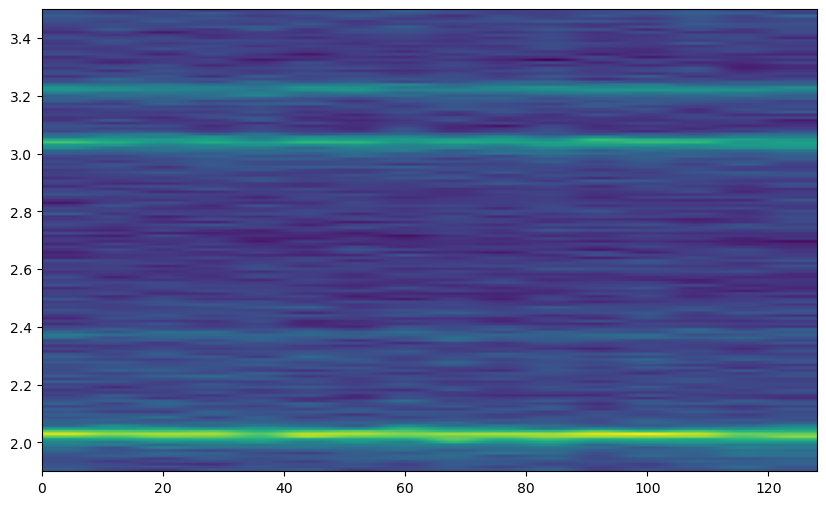

In [40]:
## apply basic freq and phase correction using RATS
data_RATS = suspect.processing.frequency_correction.correct_frequency_and_phase(cc_data, cc_data[0], method="rats")
wref_RATS = suspect.processing.frequency_correction.correct_frequency_and_phase(cc_wref, cc_wref[0], method="rats")
print(data_RATS.shape)
print(wref_RATS.shape)
spectra_RATS = data_RATS.spectrum()
freq_slice_RATS = spectra_RATS.slice_ppm(3.5, 1.9)
plt.figure(figsize=(10,6))
plt.imshow(spectra_RATS[:, freq_slice_RATS].T.real, extent=[0, 128, 1.9, 3.5], aspect='auto')

## Combine transients

With the frequency drift corrected, we can now combine the averages using a simple mean() function.

In [41]:
ave_data = np.mean(sr_data, axis=0)
ave_wref = np.mean(sr_wref, axis=0)
print(ave_data.shape)
print(ave_wref.shape)

(4096,)
(4096,)


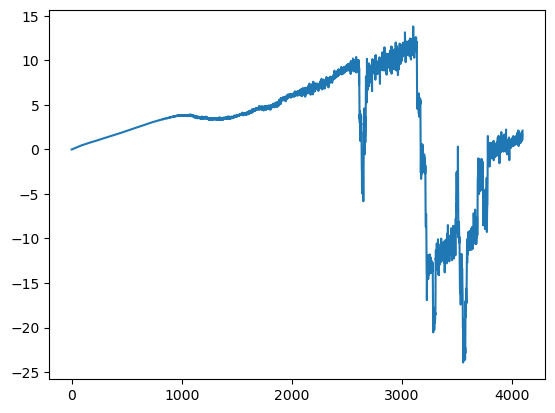

In [42]:
plt.plot(np.unwrap(np.angle(ave_wref)))

In [82]:
## save data to lcm_raw
!rm ~/data/01/P20992.7_suspect/P20992.7_lcm*
# create a parameters dictionary to set the basis set to use
params = {
    "FILBAS": BASIS_SET,
    "KEY": 210387309,
    "LPRINT": 6,
    "LTABLE": 7,
    "LPS": 8,
    "LCOORD": 9,
    "LCORAW": 10,
    "LCSV": 11,
    "ECHOT": 40.0,
    "OWNER": 'Clinical Brain Imaging Laboratory, Psychiatry Dept, Dalhousie University'
}
out_lcm_path = data_dir
out_lcm_raw_bn = os.path.join(data_dir, pfile_bn+'_lcm')
out_lcm_raw_fn = out_lcm_raw_bn+'.RAW'
out_lcm_control_fn = os.path.join(data_dir, pfile_bn+'_lcm_sl0.CONTROL')
suspect.io.lcmodel.write_all_files(out_lcm_raw_fn, ave_data, wref_data=ave_wref, params=params)

## working lcmodel .control file
```
$LCMODL
key= 210387309
nunfil= 4096
deltat= 2.000e-04
echot= 40.00
hzpppm= 1.2765e+02
filbas='press_te35_3t_gsh_v3.basis'
filraw='P20992.7_lcm.raw'
filh2o='P20992.7_lcm.h2o'
filps= 'P20992.7_lcm_out.ps'
filcoo='P20992.7_lcm_out.coord'
filcor='P20992.7_lcm_out.coraw'
filpri='P20992.7_lcm_out.print'
filtab='P20992.7_lcm_out.table'
filcsv='P20992.7_lcm_out.csv'
DOWS=T
DOECC=T
sddegp= 1.
sddegz= 3.
ppmend= 0.2
ppmst= 4.0
iaverg= 1
islice= 1
lcsv= 11
lcoraw= 10
lcoord= 9
lps= 8
ltable= 7
lprint= 6
owner= 'Clinical Brain Imaging Laboratory, Psychiatry Dept, Dalhousie University'
title= 'Exam #22967-4  ID=01  02/09/2022 14:08  presscsi  TE/TR/NS=40/3000/128  TG/R1/R2=140/13/30  8.0mL  P20992.7  (NSHA - Central Zone)'
$END
```

In [83]:
!ls -lFG ~/work/lcmodel_data/ ~/data/01/P20992.7_suspect/

/home/jovyan/data/01/P20992.7_suspect/:
total 19980
-rw-r--r-- 1 jovyan 20136628 Feb  9  2022 P20992.7
-rw-r--r-- 1 jovyan   127111 Oct 15 13:44 P20992.7_lcm.H2O
-rw-r--r-- 1 jovyan   127111 Oct 15 13:44 P20992.7_lcm.RAW
-rw-r--r-- 1 jovyan      940 Oct 15 13:44 P20992.7_lcm_sl0.CONTROL
-rw-r--r-- 1 jovyan    49072 Apr  1  2023 P20992.7_rdgehdr.txt
-rw-r--r-- 1 jovyan      892 Oct 13 19:09 suspect_convert_pfile_to_lcm_Raw.ipynb

/home/jovyan/work/lcmodel_data/:
total 536
-rw-r--r-- 1 jovyan  47315 Oct 15 12:54 P20992.7_lcm.COORD
-rw-r--r-- 1 jovyan 127215 Oct 15 12:54 P20992.7_lcm.CORAW
-rw-r--r-- 1 jovyan   2054 Oct 15 12:54 P20992.7_lcm.CSV
-rw-r--r-- 1 jovyan 127111 Oct 15 13:21 P20992.7_lcm.H2O
-rw-r--r-- 1 jovyan    598 Oct 15 12:54 P20992.7_lcm_manual.control
-rw-r--r-- 1 jovyan  35434 Oct 15 13:21 P20992.7_lcm.PDF
-rw-r--r-- 1 jovyan  45011 Oct 15 12:54 P20992.7_lcm.PS
-rw-r--r-- 1 jovyan 127111 Oct 15 13:21 P20992.7_lcm.RAW
-rw-r--r-- 1 jovyan    771 Oct 15 13:21 P20992.7_lcm_s

In [89]:
!cat ~/data/01/P20992.7_suspect/P*_lcm_sl0.CONTROL

 $LCMODL
 OWNER = ''
 KEY = 123456789
 DELTAT = 0.0002
 HZPPPM = 127.64584959999999
 NUNFIL = 4096
 FILBAS = '/home/jovyan/lcmodel/basis-sets/ge-3t/press_te35_3t_v3.basis'
 ICOLST = 1
 ICOLEN = 1
 NDCOLS = 1
 IROWST = 1
 IROWEN = 1
 NDROWS = 1
 NDSLIC = 1
 DOWS = T
 DOECC = T
 FILRAW = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.RAW'
 FILPS = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.PS'
 FILH2O = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.H2O'
 KEY = 210387309
 LPRINT = 6
 LTABLE = 7
 LPS = 8
 LCOORD = 9
 LCORAW = 10
 LCSV = 11
 ECHOT = 40.0
 OWNER = 'Clinical Brain Imaging Laboratory, Psychiatry Dept, Dalhousie University'
 FILTAB = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.TABLE'
 FILCSV = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.CSV'
 FILCOO = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.COORD'
 FILCOR = '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.CORAW'
 $END


In [85]:
myinput = open(out_lcm_control_fn)
result = subprocess.run("/home/jovyan/.lcmodel/bin/lcmodel",stdin=myinput,stdout=subprocess.PIPE)
subprocess.run(["ps2pdf",out_lcm_raw_bn+".PS",out_lcm_raw_bn+".PDF"])
print(result.stdout.decode())




          LCModel (Version 6.3-1R) Copyright: S.W. Provencher.          Ref.: Magn. Reson. Med. 30:672-679 (1993).                

  

 Data of: Clinical Brain Imaging Laboratory, Psychiatry Dept, Dalhousie University

 15-October-2023  13:57




&LCMODEL
 CHBCAL="      ",
 CHCALI= 100*"      ",
 CHCOL="-        ",
 CHEXT2= 100*"      ",
 CHGAM="gamma           ",
 CHKEEP= 500*"      ",
 CHLESS="L09   ","L20   ", 98*"      ",
 CHLSHA= 100*"      ",
 CHMORE="L13   ",
 CHNOLS="Lac   ","Ala   ", 498*"      ",
 CHOMIT= 100*"      ",
 CHPMET="Acn   ","Act   ","Ala   ","Asp   ","Bet   ",
 "bHb   ","Car   ","Cho   ","Cit   ","Cr    ","Cys   ",
 "Eth   ","Fuc   ","GABA  ","Gcn   ","Gcr   ","Glc   ",
 "Gln   ","Glu   ","Glyc  ","GPC   ","Gua   ","ILc   ",
 "Ins   ","Lac   ","Leu   ","NAA   ","NAAG  ","PAl   ",
 "PCh   ","Pgc   ","Pyr   ","Scyllo","Suc   ","Tau   ",
 "Thr   ","TMPO  ","Val   ","PCr   ","Cre   ","Gly   ",
 "mI    ","-CrCH2","Lip20 ","MM12  ","MM14  ","MM17  ",
 "MM20  ","Lip1

In [86]:
!ps2pdf

Usage: ps2pdfwr [options...] (input.[e]ps|-) [output.pdf|-]


In [87]:
subprocess.run(["ps2pdf",out_lcm_raw_bn+".PS",out_lcm_raw_bn+".PDF"])

CompletedProcess(args=['ps2pdf', '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.PS', '/home/jovyan/data/01/P20992.7_suspect/P20992.7_lcm.PDF'], returncode=0)

In [88]:
!tree /home/jovyan/work/lcmodel_data/

/home/jovyan/work/lcmodel_data/
├── P20992.7_lcm.COORD
├── P20992.7_lcm.CORAW
├── P20992.7_lcm.CSV
├── P20992.7_lcm.H2O
├── P20992.7_lcm_manual.control
├── P20992.7_lcm.PDF
├── P20992.7_lcm.PS
├── P20992.7_lcm.RAW
├── P20992.7_lcm_sl0.CONTROL
└── P20992.7_lcm.TABLE

0 directories, 10 files
